In [2]:
%matplotlib inline
import cv2  as cv
from matplotlib import pyplot as plt
import numpy as np
import os

Tamaño de la imagen: (480, 640, 3)


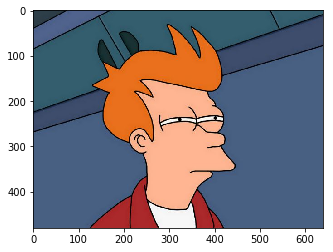

In [3]:
strImgPrueba = "ECI.Practica/Fry.jpg"
image = cv.imread(strImgPrueba,cv.IMREAD_COLOR)

# Linux funciona con BGR en vez de con RBG
image = cv.cvtColor(image,cv.COLOR_RGB2BGR)
print("Tamaño de la imagen: " + str(image.shape))

plt.imshow(image)
plt.show()

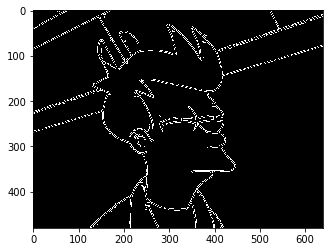

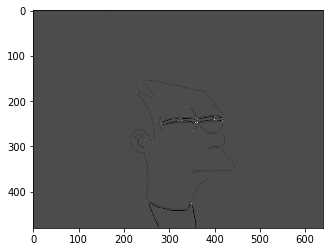

In [4]:
gris = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
blur = cv.blur(gris,(3,3))

canny = cv.Canny(gris,10,100)

plt.imshow(canny,cmap="gray")
plt.show()

harris = cv.cornerHarris(gris,2,3,0.04)

plt.imshow(harris,cmap="gray")
plt.show()

In [5]:
# Cómputo de descriptores HOG
cv.normalize(harris, harris, 0, 255, cv.NORM_MINMAX)        
cv.convertScaleAbs(harris, harris)

hog = cv.HOGDescriptor()
descriptors = hog.compute(image)

d_size = descriptors.shape
blockSize = hog.blockSize
winSize = hog.winSize
blockStride = hog.blockStride
cellsize = hog.cellSize
n_bins = hog.nbins
descriptor_size = hog.getDescriptorSize()

print("HOG ("+str(descriptors.shape)+"): "+
    "block size: "+str(blockSize)+
    ", windows size: "+str(winSize)+
    ", stride size: "+str(blockStride)+
    ", cell size: "+str(cellsize) +
    ", number of bins " + str(n_bins)+
    ", descriptor size: "+str(descriptor_size))


HOG ((12417300, 1)): block size: (16, 16), windows size: (64, 128), stride size: (8, 8), cell size: (8, 8), number of bins 9, descriptor size: 3780


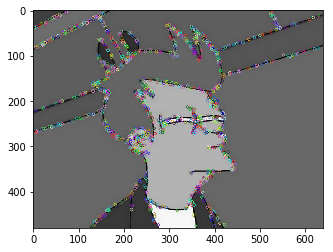

In [6]:
# Otro descriptor
fd = cv.FastFeatureDetector.create()
sift = fd.detect(gris)
siftImage = cv.drawKeypoints(gris,sift,np.array([]))

plt.imshow(siftImage,cmap="gray")
plt.show()

In [7]:
# Direcciones de las imágenes
PATH_POSITIVE_TRAIN = "ECI.Practica/data/train/pedestrians/"
PATH_NEGATIVE_TRAIN = "ECI.Practica/data/train/background/"
PATH_POSITIVE_TEST = "ECI.Practica/data/test/pedestrians/"
PATH_NEGATIVE_TEST = "ECI.Practica/data/test/background/"
EXAMPLE_POSITIVE = PATH_POSITIVE_TEST + "AnnotationsPos_0.000000_crop_000011b_0.png"
EXAMPLE_NEGATIVE = PATH_NEGATIVE_TEST+"AnnotationsNeg_0.000000_00000002a_0.png"


In [8]:
# Función para cargar las imágenes.
def loadTrainingData():
    trainingData = []
    classes = []
    
    for file in os.listdir(PATH_POSITIVE_TRAIN):
        img = cv.imread(PATH_POSITIVE_TRAIN+file,cv.IMREAD_COLOR)
        
        hog = cv.HOGDescriptor()
        descriptor = hog.compute(img)
        trainingData.append(descriptor.flatten())
        classes.append(np.ones((1,1),dtype=np.int32))
        
    print("Leidas " + str(len(
        [name for name in os.listdir(PATH_POSITIVE_TRAIN) if os.path.isfile(os.path.join(PATH_POSITIVE_TRAIN, name)) ]))
         + " imágenes de entrenamiento -> positivas")
        
    for file in os.listdir(PATH_NEGATIVE_TRAIN):
        img = cv.imread(PATH_NEGATIVE_TRAIN+file,cv.IMREAD_COLOR)
        
        hog = cv.HOGDescriptor()
        descriptor = hog.compute(img)
        trainingData.append(descriptor.flatten())
        classes.append(np.zeros((1,1),dtype=np.int32))
       
        
    print("Leidas " + str(len(
        [name for name in os.listdir(PATH_NEGATIVE_TRAIN) if os.path.isfile(os.path.join(PATH_NEGATIVE_TRAIN, name)) ]))
         + " imágenes de entrenamiento -> negativas")
    
    trainingData = np.array(trainingData)
    classes = np.array(classes,dtype=np.int32)
        
    return trainingData,classes

In [9]:
trainingData,classes = loadTrainingData()

Leidas 1916 imágenes de entrenamiento -> positivas
Leidas 2390 imágenes de entrenamiento -> negativas


In [10]:
# Función para crear un SVM y entrarnalo con las imágenes.
def train(trainingData,classes):
    svm = cv.ml.SVM_create()
    svm.setKernel(cv.ml.SVM_LINEAR)
    svm.setType(cv.ml.SVM_C_SVC)
    svm.train(trainingData,cv.ml.ROW_SAMPLE,classes)
    
    return svm

In [11]:
svm = train(trainingData,classes)

In [12]:
# Función para realizar una predicción.
def test(image,clasificador):
    # Computamos HOG.
    hog = cv.HOGDescriptor()
    descriptor = hog.compute(image)
    return clasificador.predict(np.mat(descriptor.flatten(),dtype=np.float32))

In [13]:
# Función de ejemplo de clasificador.
def ejemploClasificadorImagenes():
    trainingData,classes = loadTrainingData()
    svm = train(trainingData,classes)
    print("Clasificador entrenado")
    
    image = cv.imread(EXAMPLE_POSITIVE,cv.IMREAD_COLOR)
    if(image.size == 0):
        print("Cannot load image")
        return
    
    prediction = test(image,svm)
    print("Predicción: " + str(prediction))
    
# Ejemplo con la imagen positiva
ejemploClasificadorImagenes()

Leidas 1916 imágenes de entrenamiento -> positivas
Leidas 2390 imágenes de entrenamiento -> negativas
Clasificador entrenado
Predicción: (0.0, array([[1.]], dtype=float32))


In [45]:
# Función para leer las imágenes de test
def loadTestData():
    testData = []
    classes = []
    
    for file in os.listdir(PATH_POSITIVE_TEST):
        img = cv.imread(PATH_POSITIVE_TEST+file,cv.IMREAD_COLOR)
        
        testData.append(img)
        classes.append(np.ones((1,1),dtype=np.int32))
        
    print("Leidas " + str(len(
        [name for name in os.listdir(PATH_POSITIVE_TEST) if os.path.isfile(os.path.join(PATH_POSITIVE_TEST, name)) ]))
         + " imágenes de entrenamiento -> positivas")
        
    for file in os.listdir(PATH_NEGATIVE_TEST):
        img = cv.imread(PATH_NEGATIVE_TEST+file,cv.IMREAD_COLOR)
        
        testData.append(img)
        classes.append(np.zeros((1,1),dtype=np.int32))
       
        
    print("Leidas " + str(len(
        [name for name in os.listdir(PATH_NEGATIVE_TEST) if os.path.isfile(os.path.join(PATH_NEGATIVE_TEST, name)) ]))
         + " imágenes de entrenamiento -> negativas")
    
    testData = np.array(testData)
    classes = np.array(classes,dtype=np.int32)
        
    return testData,classes

testData,classesTest = loadTestData()

Leidas 500 imágenes de entrenamiento -> positivas
Leidas 600 imágenes de entrenamiento -> negativas


In [54]:
def predictTest(clasif,testData):
    return [test(image, clasif) for image in testData]

predict_test = predictTest(svm, testData)
clases_imagenes = [dato[1] for dato in predict_test]
    
clases_imagenes = np.array(clases_imagenes, dtype=np.int32)

# Calculamos el accuracy.
iguales = np.equal(clases_imagenes,classesTest)
accuracy = sum(iguales==True)/iguales.size
accuracy

array([[0.96727273]])